In [1]:
%matplotlib notebook

import pyarrow.parquet as pq
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from scipy.optimize import linprog
import pandas as pd
import datetime as dt

In [2]:
# loading dataframe
df = pq.read_table('model_ready.parquet').to_pandas()

# Load data

In [3]:
# defining target variables
output = ['da_energy_aeci_lmpexpost_ac', 'da_energy_michigan_hub_lmpexpost_ac', 'da_energy_minn_hub_lmpexpost_ac']
features = df.columns.drop(output + ['row_type'])

df_train = df.loc[df.row_type=='train']
df_test = df.loc[df.row_type=='hold_out']

# splitting datasets into train, test inputs and outputs
y_train = df_train[output]
x_train = df_train[features]
y_test = df_test[output]
x_test = df_test[features]

# EDA and correlation analysis

In [4]:
# check that all columns have all data
df.isna().sum().eq(0).all()

True

Below is a mutual information (MI) based analysis of correlation between features and prices at different nodes. MI describes relationships in terms of uncertainty. The MI between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

In [5]:
# plot correlation of features to targets

def make_mi_scores(X, y, col_name):
    mi_scores = mutual_info_regression(X, y)
    if isinstance(X, np.ndarray):
        return mi_scores
    mi_scores = pd.Series(mi_scores, name=col_name, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def compile_mi_scores(X, y, col_names):
    df_list = []
    for col_name in col_names:
        df_list.append(make_mi_scores(X, y[col_name], col_name))
       
    return pd.concat(df_list, axis=1)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("MI Scores - {}".format(scores.name))
    plt.tight_layout()
    


<IPython.core.display.Javascript object>


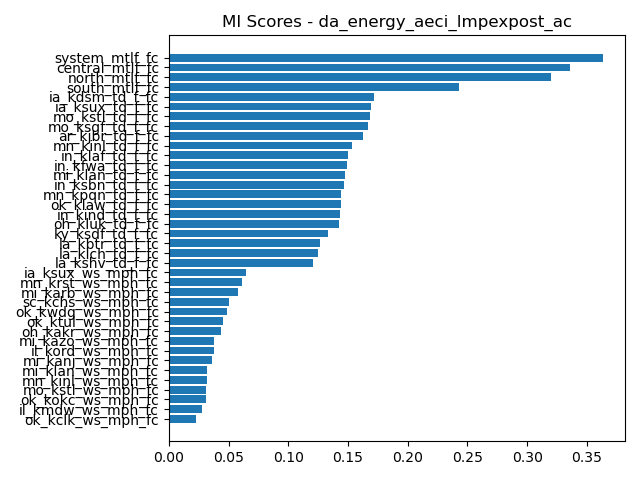

<IPython.core.display.Javascript object>


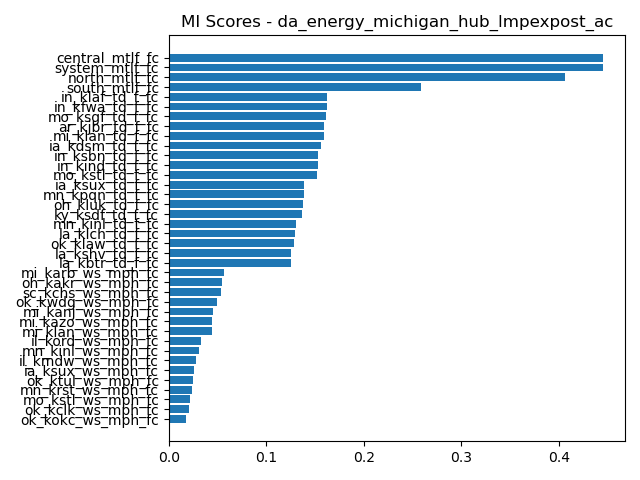

<IPython.core.display.Javascript object>


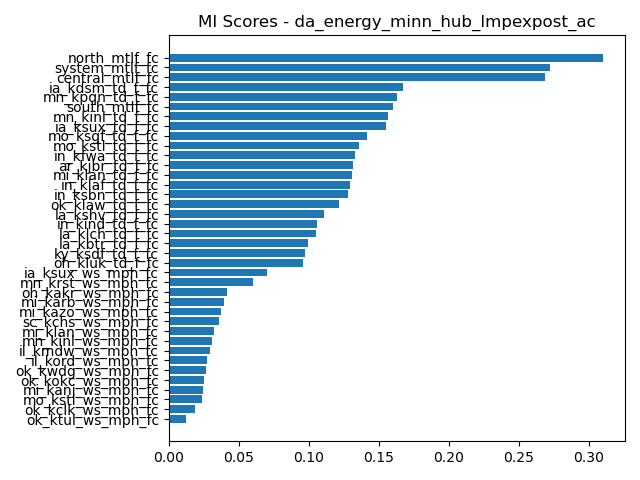

In [6]:
mi_scores = compile_mi_scores(x_train[features], y_train, y_train.columns)

plt.figure()
plot_mi_scores(mi_scores.da_energy_aeci_lmpexpost_ac)

plt.figure()
plot_mi_scores(mi_scores.da_energy_michigan_hub_lmpexpost_ac)

plt.figure()
plot_mi_scores(mi_scores.da_energy_minn_hub_lmpexpost_ac)

In the plots above, we see that the features have more predictive power for node `da_energy_michigan_hub_lmpexpost_ac`. This means we might be able to forecast prices at this node with better accuracy (this is confirmed below). Further, the top 3 informative features for all three nodes are:
* `north_mtlf_fc`
* `system_mtlf_fc`
* `central_mtlf_fc`

# Price forecaster for different look-ahead horizons
The first step in this approach is to build a price forecaster for each grid node using the training data. 
The forecaster should take as inputs the available features and generate prices for the three grid nodes.
To build a forecaster,  I used Light GBM which is one of the top-performing ML regression algorithms. 
For tuning, I then use k-fold cross validation using the training set so that the hold-out dataset is kept for testing.

One assumption that is made here is that the forecasted values for all features are available for the entire look-ahead period e.g., if the goal is to forecast prices for the next 24 hours all of the forecasts of the input features are available for those 24 hours. 

In [7]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# the hyperparameter tuning for the price forecasters of all three nodes takes some time to run and
# thus I commented it and saved the output in the next cell 

# # setting the parameters of LightGBM
# param_grid= {'max_depth':[4,5,6,7,8],
#              'n_estimators':[75,100,125,150,200],
#              'num_leaves':[4,5,6,7,8,9],
#              'learning_rate':[0.01,0.05, 0.1,0.11,0.12,0.13,0.15]
#             }

# param = {}

# # find best hyperparameters for each node's price forecaster
# for grid_node in range(3):
#     model = lgb.LGBMRegressor()
#     cv = TimeSeriesSplit(max_train_size=720)
#     search = GridSearchCV(model, param_grid, cv=cv).fit(x_train, y_train.iloc[:,grid_node])
#     param[grid_node] = search.best_params_


In [8]:
# saved to not have to re-run CV every time
param = {0: {'learning_rate': 0.11,
  'max_depth': 5,
  'n_estimators': 150,
  'num_leaves': 6},
 1: {'learning_rate': 0.11,
  'max_depth': 5,
  'n_estimators': 200,
  'num_leaves': 9},
 2: {'learning_rate': 0.05,
  'max_depth': 7,
  'n_estimators': 125,
  'num_leaves': 9}}

In [9]:
# function to calculate mse, rmse of the model and plot actual and predicted prices
def evaluate_model(model, x_test, y_test):
    # prediction
    y_pred = model.predict(x_test)

    # accuracy check
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    
    plt.figure()
    plt.plot(y_test.index, y_test, label='actual')
    plt.plot(y_test.index, y_pred, label='predicted')
    plt.title("grid node: %s MSE: %.2f RMSE: %.2f" % (y_test.name, mse, rmse))
    plt.legend()

<IPython.core.display.Javascript object>


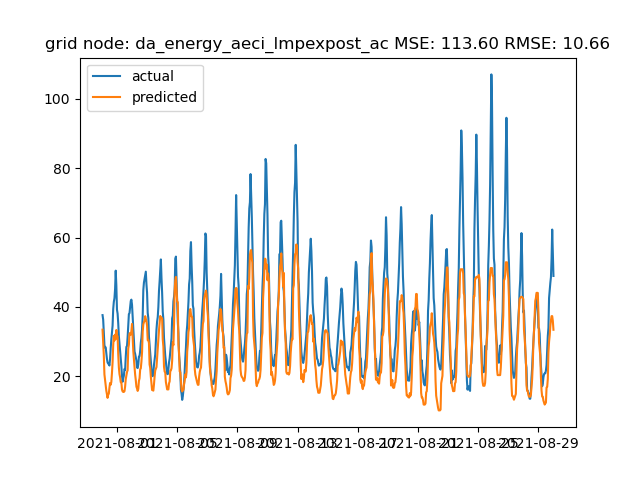

<IPython.core.display.Javascript object>


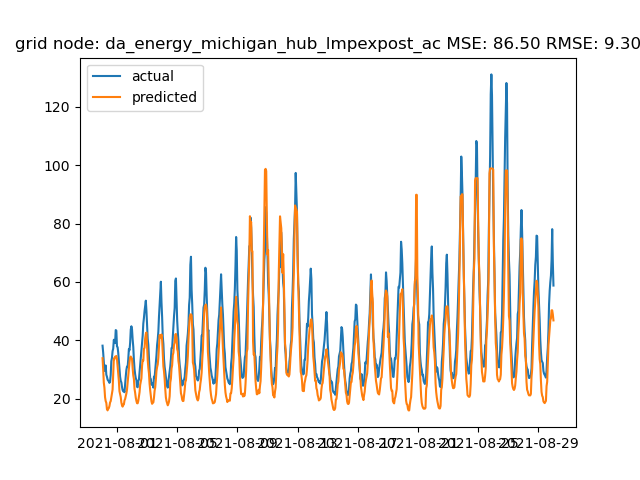

<IPython.core.display.Javascript object>


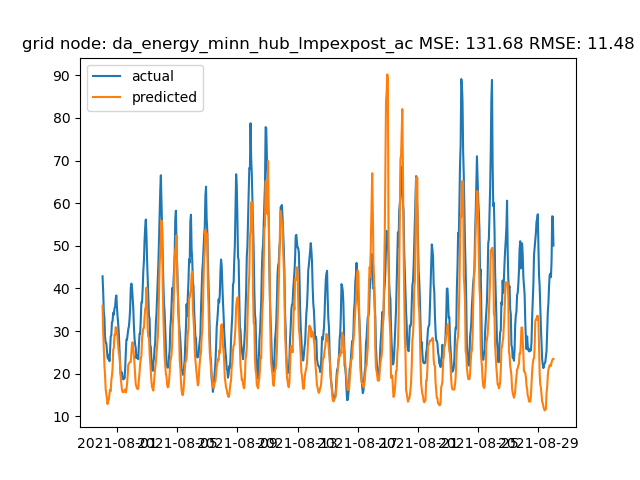

In [10]:
models = {}

# fitting models and plotting actual and predicted prices (all three grid nodes)
for grid_node in range(3):

    # fitting the model
    model = lgb.LGBMRegressor(**param[grid_node])
    model.fit(x_train, y_train.iloc[:,grid_node])
    models[grid_node] = model
    evaluate_model(model, x_test, y_test.iloc[:,grid_node])
    

# Model predictive Control Approach to Computing Battery Bids and Offers

We assume that at time t we have forecasts (features) for the next look-ahead period. In the analysis, I considered look-ahead periods ranging from 12 to 120 hours. Using the price forecasters, I predict energy prices for the look-ahead period in all three grid nodes. Then, the bidding strategy is as follows:
* For each node, I solve a look-ahead optimization problem for the look-ahead period, using the forecasted prices and incorporate all constraints associated with the battery storage devices and come up with `Psd` and `Psc`, the discharging and charging commands for each hour of the look-ahead horizon corresponding to that node.
* Then our order for t+1 will be the commands for the first hour that correspond to the node with maximum profit over the look-ahead horizon specifically to sell `Psd[0]` (if `Psd[0]>0`) or buy if `Psc[0]` (if `Psc[0]>0`) i.e., our bid will be the output of the optimization problem for hour 1 of the look-ahead horizon of the most profitable grid node and will be to sell if the discharge variable is greater than zero or to buy if the charge variable is greater than zero.
* At t+1, we repeat this process.





In [11]:
# function to plot profits, state of charge and prices
def plot_results(pr, soc, profit, h):
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    ax[0].plot(range(len(pr)), pr, 'b', label='prices [$]')
    ax[0].plot(range(len(soc)), soc, 'g', label='state of charge [MWh]')
    ax[1].plot(range(len(profit)), np.cumsum(profit), 'r', label='profit [$]')

    ax[0].legend()
    ax[1].legend()
    plt.suptitle('Total profit ({}h look-ahead horizon): {}'.format(h, sum(profit)))

# Battery storage look-ahead optimization problem (model predictive control)

The battery storage optimization problem for the look-ahead horizon can be stated as:

$ \max \sum_{i=1}^{24} (\lambda_{D,i}-1)P_{sd,i} +(\lambda_{D,i}+1)(-P_{sc,i}) $


$E_s,0=E_{s,max}=10$


$E_{s,i}=E_{s,i-1}+efficiency*P_{sc,i}-\frac{1}{efficiency}*P_{sd,i}$


$E_{s,i}\leq 10$


$E_{s,i}\geq 0$


$P_{sd,i}\geq 0$


$P_{sc,i}\geq 0$

This problem can be compactly written as a standard linear program which can be solved using linprog shown below:

$ \min_{x} obj(x)= Wx$

$A_{ub}x\leq B_{ub}$

In [12]:
# function that solves the optimization described above and generates optimal charging and discharging commands
# over different look-ahead horizons based on the forecasted node prices

def get_optimal_bid(price, E_s, h):
    n_var = 2
    b_ub_0 = np.ones((h,1))*(10-E_s)
    b_ub_10 = np.ones((h,1))*(E_s)
    
    b_ub = np.concatenate((b_ub_0, b_ub_10, np.zeros((h*n_var,1))), axis=0)

    n = 0.8
    A1 = np.tril(np.ones((h,h))*n)
    A2 = np.tril(np.ones((h,h))*(-1/n))

    A_ub_0 = np.concatenate((A1,A2), axis=1)
    A_ub = np.concatenate((A_ub_0, -A_ub_0, -np.eye(h*n_var)), axis=0)

    obj = np.concatenate((price+1, -price+1), axis=0).flatten()

    result = linprog(obj, A_ub=A_ub, b_ub=b_ub)
    return result.x[0], result.x[h], result.fun


# Details of the bidding algorithm
This code evaluates different look-ahead horizons as described above. For each time `t` of the hold_out set and for each node, the forecasted prices for the whole horizon are used as input to a linear programming optimization solver that generates optimal charging and discharging commands and maximum profit. The commands that correspond to the node that gives maximum profit are then used to generate market bids for the next hour.

Below, one can see that the look-ahead horizon that maximizes the profits for the battery storage is 24 hours.


<IPython.core.display.Javascript object>


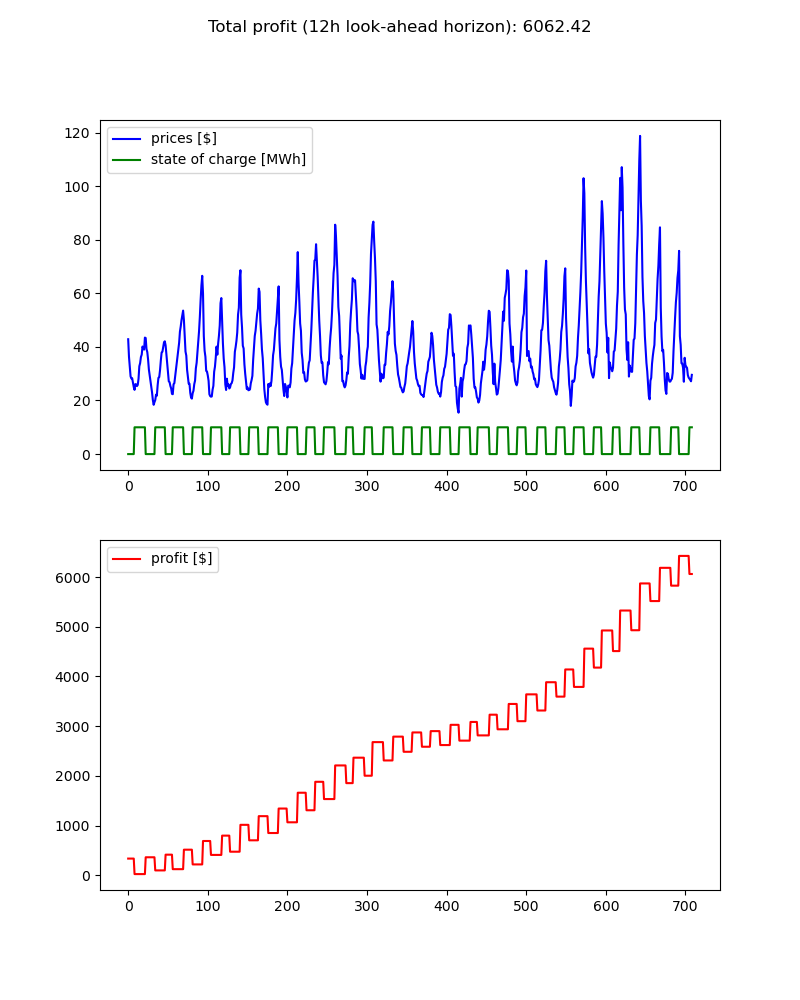

<IPython.core.display.Javascript object>


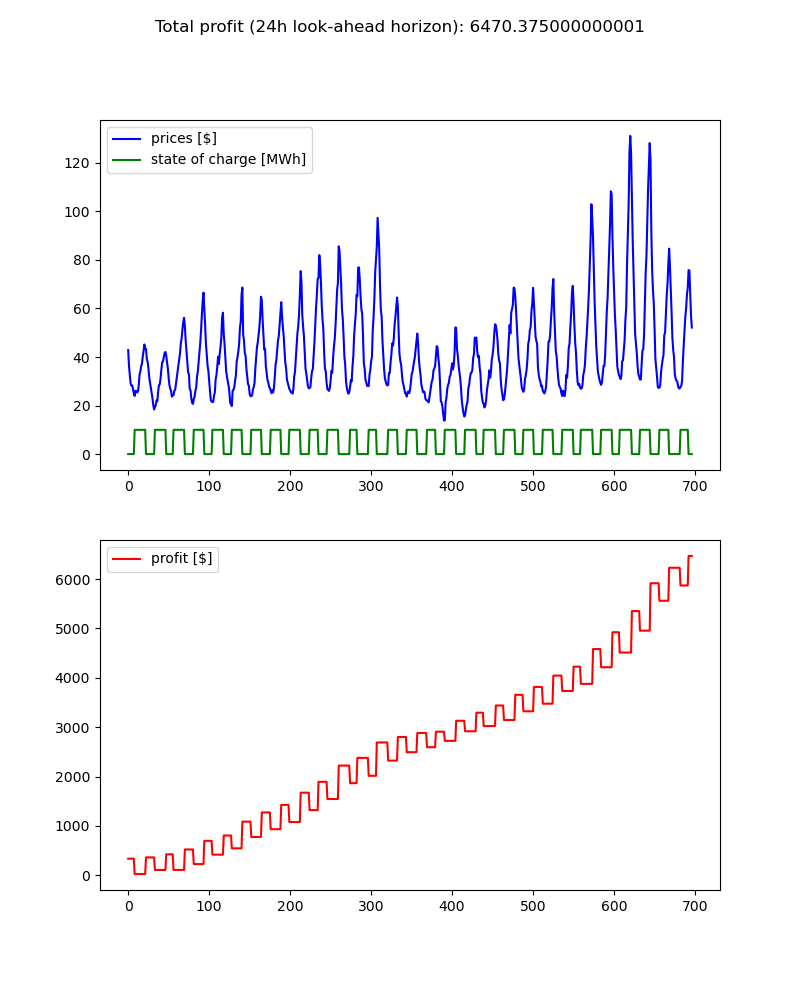

<IPython.core.display.Javascript object>


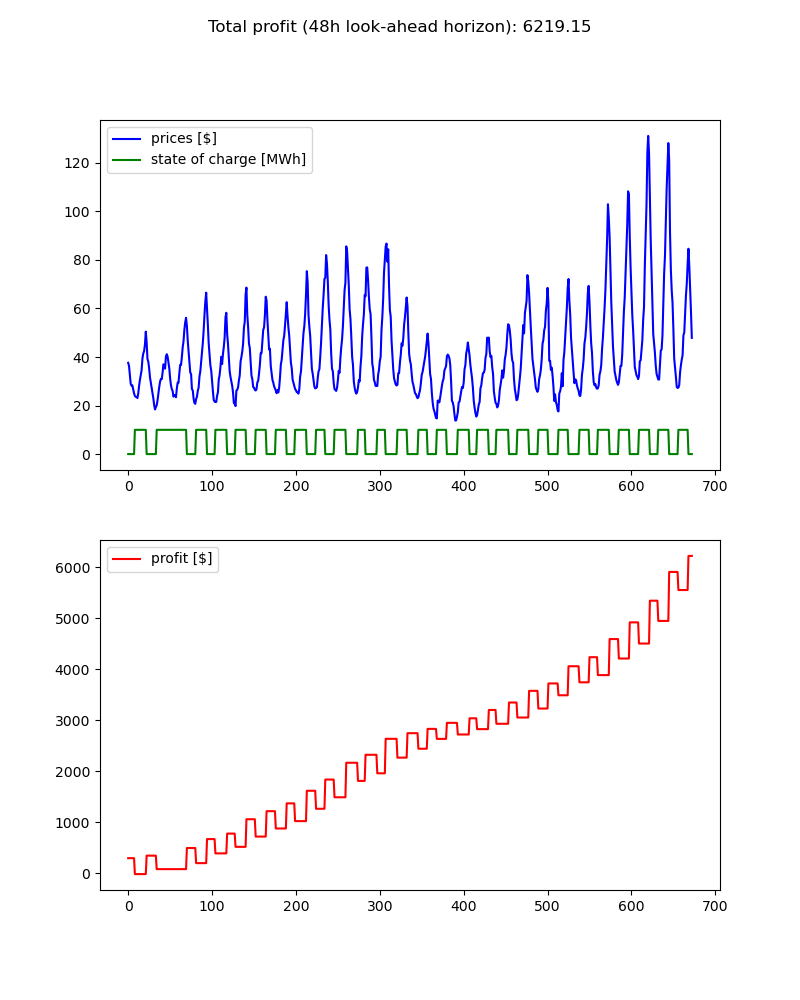

<IPython.core.display.Javascript object>


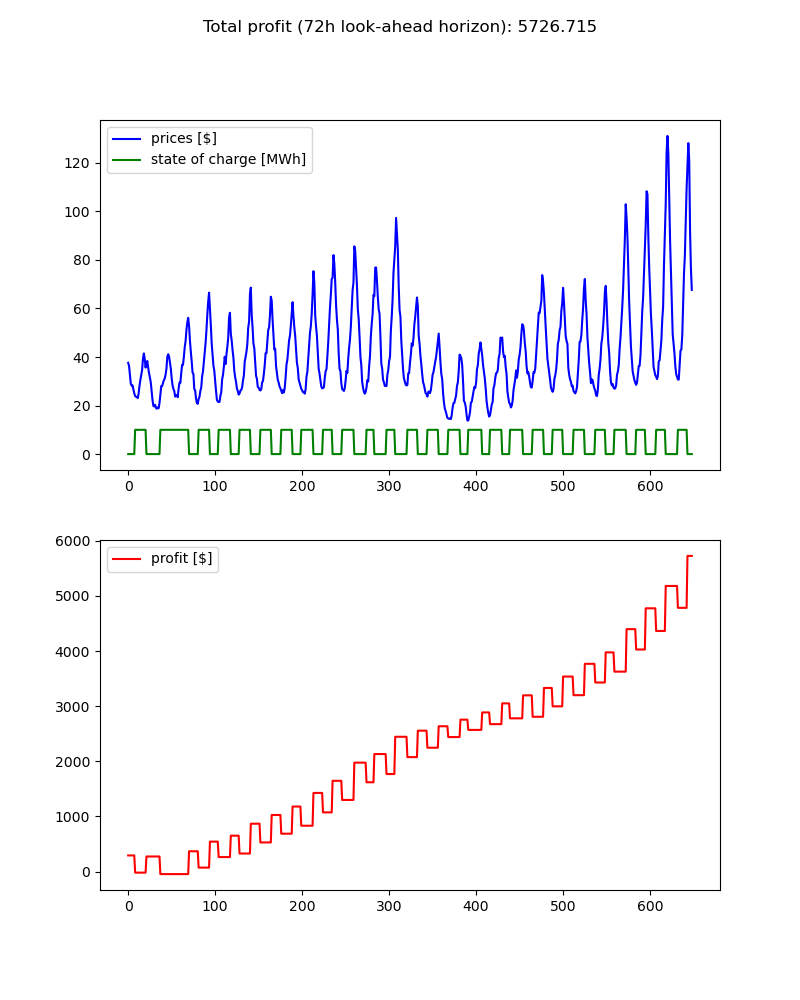

<IPython.core.display.Javascript object>


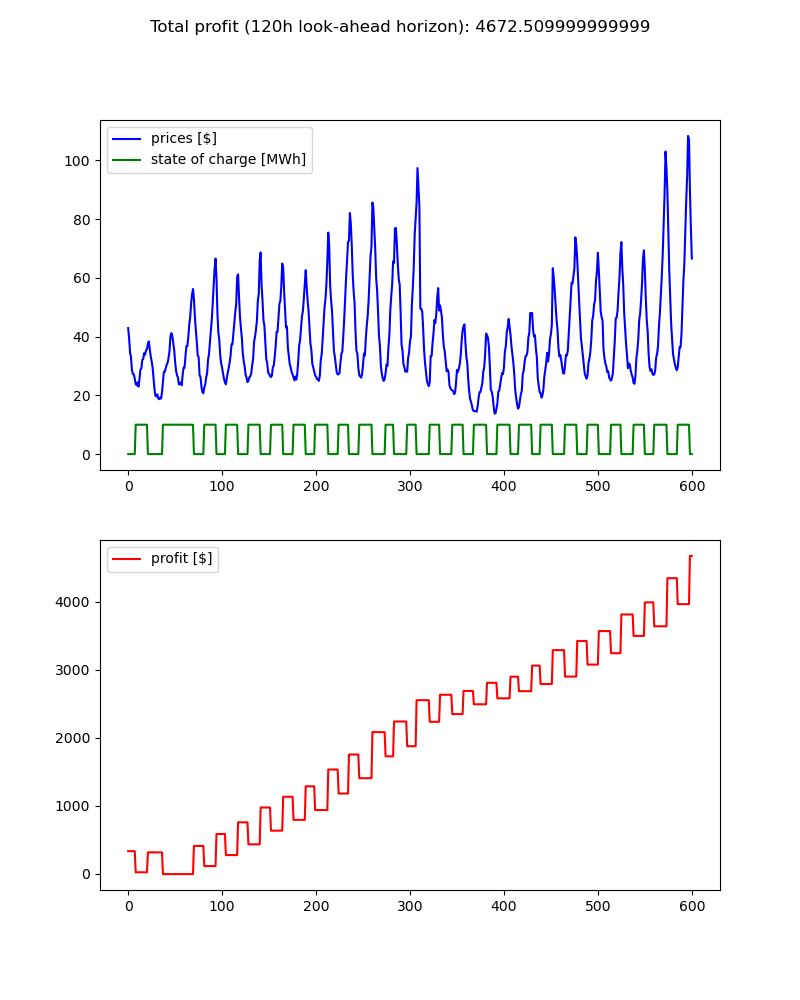

In [13]:


eff_factor = 0.8

for h_look_ahead in [12, 24, 48, 72, 120]:
    soc = []
    pr = []
    profit = []
    E_s = 10

    for t in range(0, x_test.shape[0]-h_look_ahead+1):
        x_look_ahead=x_test.iloc[t:t+h_look_ahead,:]
        
        max_profit = -np.inf
        final_price = None
        
        for grid_node in range(3):
            prices_fc = models[grid_node].predict(x_look_ahead)
            prices_act =  y_test.iloc[t,grid_node]

            Psc, Psd, cost = get_optimal_bid(prices_fc, E_s, h_look_ahead)
            if -cost > max_profit:
                max_profit = -cost
                opt_Psc = Psc
                opt_Psd = Psd
                final_price = prices_act
            
        pr.append(final_price)
        
        profit.append((final_price-1)*opt_Psd -(final_price+1)*opt_Psc)
        E_s = E_s + eff_factor*opt_Psc - (1/eff_factor)*opt_Psd
        soc.append(E_s)

    plot_results(pr, soc, profit, h_look_ahead)

# Baseline model
Looking at median prices per hour over all three grid nodes, one can see that, on average, the price is lowest in `da_energy_aeci_lmpexpost_ac` at 8AM UTC, and highest in `da_energy_michigan_hub_lmpexpost_ac` at midnight UTC. Therefore, the baseline strategy will be to sell as much charge as possible every day at midnight UTC, and buy as much as possible at 8AM UTC at the corresponding nodes.

In [14]:
y = df[output].reset_index()
y['hour'] = y.interval_ending_dt_utc.dt.hour
y.groupby('hour').median().agg(['min','idxmin','max','idxmax'])

,da_energy_aeci_lmpexpost_ac,da_energy_michigan_hub_lmpexpost_ac,da_energy_minn_hub_lmpexpost_ac
min,14.17,18.53,14.69
idxmin,8.00,8.00,9.00
max,24.98,28.59,24.68
idxmax,0.00,0.00,0.00


# Explanation of base strategy 

For each time t of the hold_out set, if the hour is 0 and the battery has some charge to sell it discharges fully (sells power to the grid) at node `da_energy_michigan_hub_lmpexpost_ac` while if the hour is 8 and the battery can be charged more then we charge fully (buy power from the grid) at node `da_energy_aeci_lmpexpost_ac`.

<IPython.core.display.Javascript object>


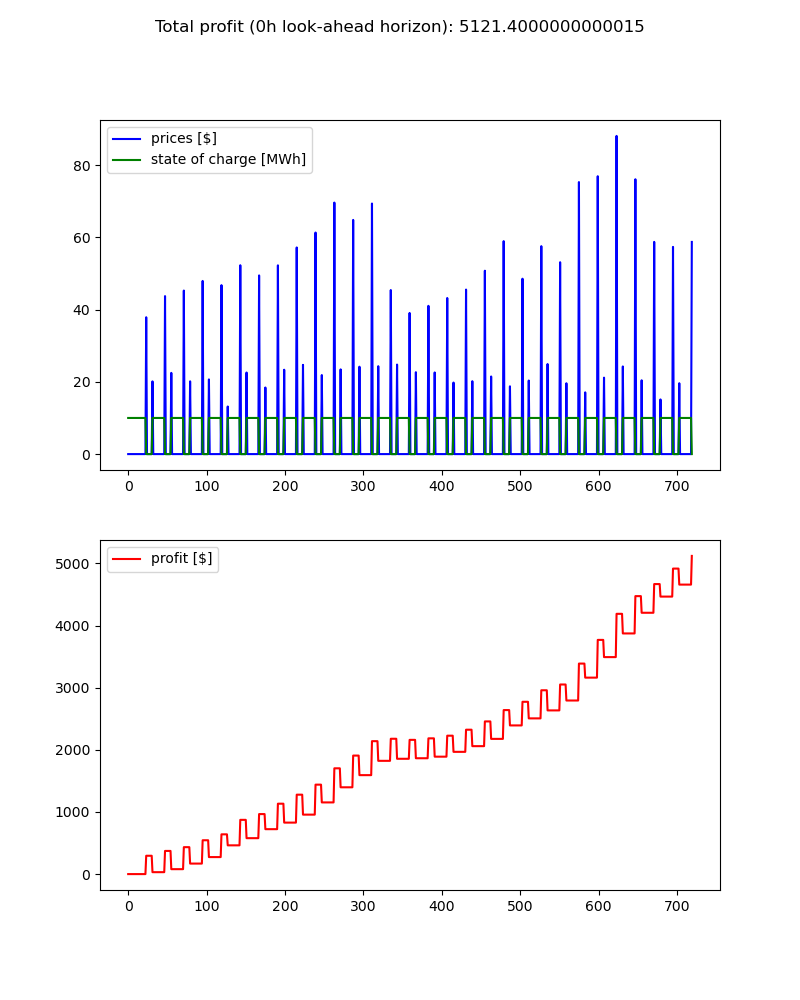

In [15]:
E_s = 10
pr = []
profit = []
soc = []
y_test = y_test.reset_index()

y_test['hour'] = y_test.interval_ending_dt_utc.dt.hour

for idx, row in y_test.iterrows():
    if row.hour==0 and E_s>0:
        #sell
        Psd = 8
        Psc = 0
        price = row.da_energy_michigan_hub_lmpexpost_ac
    elif row.hour==8 and E_s<10:
        #buy
        Psd = 0
        Psc = 12.5
        price = row.da_energy_aeci_lmpexpost_ac
    else:
        #do nothing
        Psd = 0
        Psc = 0
        price=0

    pr.append(price)

    profit.append((price-1)*Psd -(price+1)*Psc)
    E_s = E_s + eff_factor*Psc - (1/eff_factor)*Psd
    soc.append(E_s)

plot_results(pr, soc, profit, 0)

# Discussion of results

One can see that the optimal strategy corresponding to the 24-hour look-ahead horizon outperforms the baseline generating `$`6470.38 vs `$`5121.40 that the baseline strategy generates. 